# EDA/Insights/Analytics Questions

The dataset is from Kaggle [Retail Transaction Dataset](https://www.kaggle.com/datasets/fahadrehman07/retail-transaction-dataset)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [2]:
raw_data = pd.read_csv("data/Retail_Transaction_Dataset.csv")
raw_data.head()

,CustomerID,ProductID,Quantity,Price,TransactionDate,PaymentMethod,StoreLocation,ProductCategory,DiscountApplied(%),TotalAmount
0,109318,C,7,80.079844,12/26/2023 12:32,Cash,"176 Andrew Cliffs\nBaileyfort, HI 93354",Books,18.677100,455.862764
1,993229,C,4,75.195229,8/5/2023 0:00,Cash,"11635 William Well Suite 809\nEast Kara, MT 19483",Home Decor,14.121365,258.306546
2,579675,A,8,31.528816,3/11/2024 18:51,Cash,"910 Mendez Ville Suite 909\nPort Lauraland, MO...",Books,15.943701,212.015651
3,799826,D,5,98.880218,10/27/2023 22:00,PayPal,"87522 Sharon Corners Suite 500\nLake Tammy, MO...",Books,6.686337,461.343769
4,121413,A,7,93.188512,12/22/2023 11:38,Cash,"0070 Michelle Island Suite 143\nHoland, VA 80142",Electronics,4.030096,626.030484


In [3]:
df = raw_data.copy()

df.dtypes

CustomerID              int64
ProductID              object
Quantity                int64
Price                 float64
TransactionDate        object
PaymentMethod          object
StoreLocation          object
ProductCategory        object
DiscountApplied(%)    float64
TotalAmount           float64
dtype: object

In [4]:
# Convert TransactionDate to datetime items

convert_dt = lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M")
df["trans_time"] = df["TransactionDate"].apply(convert_dt)
df["trans_date"] = df["trans_time"].apply(lambda x: x.date())


# Promo penetration
df["promo_pen"] = df["DiscountApplied(%)"]/( df["DiscountApplied(%)"] + df["TotalAmount"])

In [5]:
df.head()

,CustomerID,ProductID,Quantity,Price,TransactionDate,PaymentMethod,StoreLocation,ProductCategory,DiscountApplied(%),TotalAmount,trans_time,trans_date,promo_pen
0,109318,C,7,80.079844,12/26/2023 12:32,Cash,"176 Andrew Cliffs\nBaileyfort, HI 93354",Books,18.677100,455.862764,2023-12-26 12:32:00,2023-12-26,0.039358
1,993229,C,4,75.195229,8/5/2023 0:00,Cash,"11635 William Well Suite 809\nEast Kara, MT 19483",Home Decor,14.121365,258.306546,2023-08-05 00:00:00,2023-08-05,0.051835
2,579675,A,8,31.528816,3/11/2024 18:51,Cash,"910 Mendez Ville Suite 909\nPort Lauraland, MO...",Books,15.943701,212.015651,2024-03-11 18:51:00,2024-03-11,0.069941
3,799826,D,5,98.880218,10/27/2023 22:00,PayPal,"87522 Sharon Corners Suite 500\nLake Tammy, MO...",Books,6.686337,461.343769,2023-10-27 22:00:00,2023-10-27,0.014286
4,121413,A,7,93.188512,12/22/2023 11:38,Cash,"0070 Michelle Island Suite 143\nHoland, VA 80142",Electronics,4.030096,626.030484,2023-12-22 11:38:00,2023-12-22,0.006396


# 1. Exploratory DataSet

## 1.1 Revenue




In [6]:
import matplotlib.pyplot as plt

<Axes: xlabel='trans_month'>

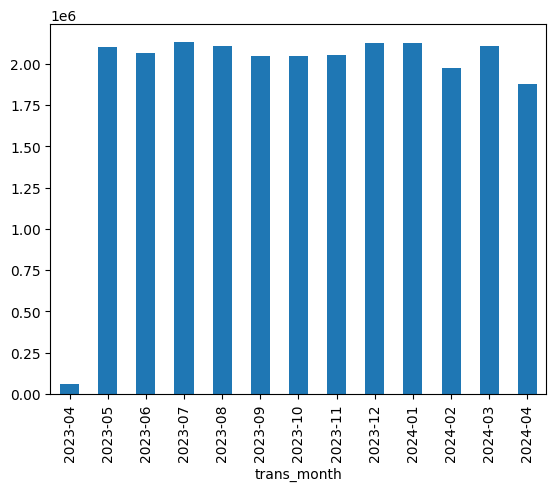

In [7]:
# Revenue by month
df["trans_month"] = df["trans_time"].apply(lambda x: x.strftime("%Y-%m"))
df_by_month = df[["TotalAmount", "trans_month"]].groupby("trans_month").sum()

df_by_month.plot(kind="bar", legend=False)


Wieldly steady monthly transactions. No seasonality. No trend. No growth.

<Axes: xlabel='ProductCategory'>

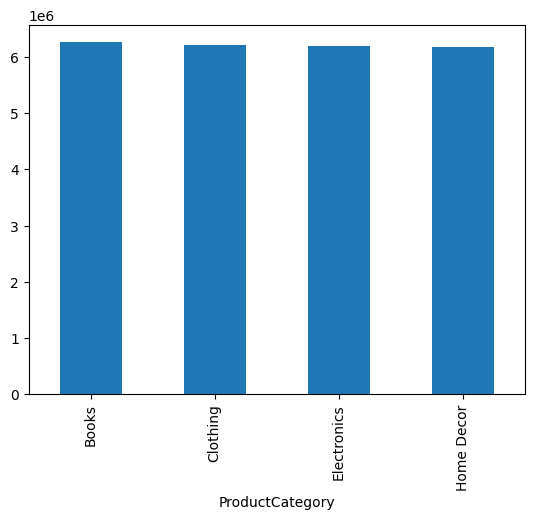

In [8]:
# Revenue by category
df_by_cat = df[["TotalAmount", "ProductCategory"]].groupby("ProductCategory").sum()

df_by_cat.plot(kind="bar", legend=False)


## 1.2 Customer

### 1.2.1 Customer_cnt by month

<Axes: xlabel='trans_month'>

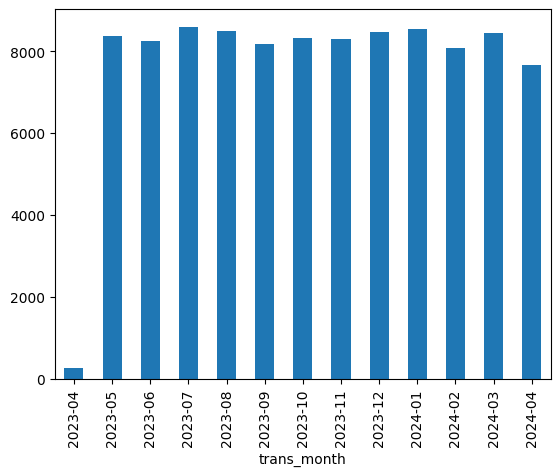

In [9]:
monthly_cnt = df[["trans_month", "CustomerID"]].groupby("trans_month").size()

monthly_cnt.plot(kind="bar", legend=False)

### 1.2.2 New customer count

<Axes: xlabel='trans_month'>

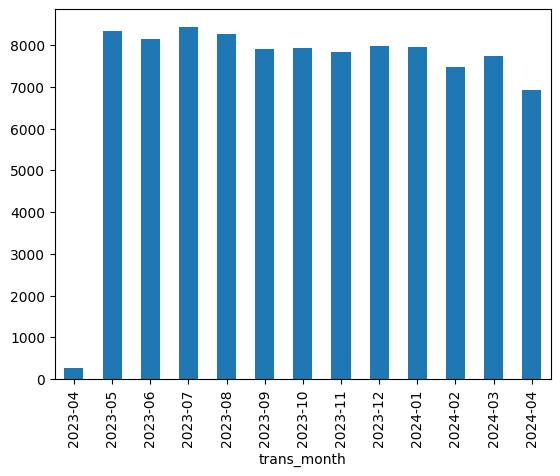

In [10]:
first_time_purchase = df[["CustomerID", "trans_month"]].groupby(["CustomerID"]).min()
new_customer_aquisition = first_time_purchase.groupby(["trans_month"]).size()
new_customer_aquisition.plot(kind="bar", legend=False)

In [11]:
print("**Insight 1**: The count of new customers are declining.")

**Insight 1**: The count of new customers are declining.


### 1.2.3 Customer Rentention: How many customers come back 30 days after the first purchase?

In [12]:
install_dates  = df[["CustomerID", "trans_date"]].groupby(["CustomerID"]).min().reset_index().rename(columns={"trans_date": "first_trans_date"})

install_dates["after_30_days"] = install_dates["first_trans_date"].apply(lambda x: x + timedelta(days=30))

next_day_activity = pd.merge(
    install_dates, df, on="CustomerID"
)

next_day_activity = next_day_activity[(next_day_activity["first_trans_date"] < next_day_activity["trans_date"]) 
                  & 
                  (next_day_activity["after_30_days"] >= next_day_activity["trans_date"])
                 ]

return_customers = next_day_activity[["CustomerID", "first_trans_date"]].groupby(["first_trans_date"]).size().reset_index()
return_customers.columns = ["first_trans_date", "return_cnt"]

<Axes: >

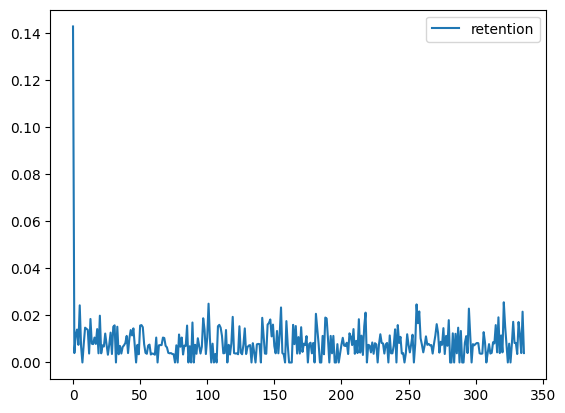

In [13]:
install_dates_agg = install_dates.groupby(["first_trans_date"]).size().reset_index()
install_dates_agg.columns = ["first_trans_date", "cnt"]

daily_retention = pd.merge(install_dates_agg, return_customers, on="first_trans_date", how="left")
daily_retention["return_cnt"] = daily_retention["return_cnt"].fillna(0)
daily_retention["retention"] = daily_retention["return_cnt"]/daily_retention["cnt"]
daily_retention["retention"] = daily_retention["retention"].apply(lambda x: round(x, 4))

daily_retention = daily_retention.loc[0:len(daily_retention)-30]

daily_retention[["first_trans_date", "retention"]].plot(kind="line")

In [14]:
overall_retention = daily_retention["return_cnt"].sum()/daily_retention["cnt"].sum()
print("**Insight 2**: The overall retention rate is {}.".format(round(overall_retention, 4)))

**Insight 2**: The overall retention rate is 0.0081.


In [15]:
def add_label(df):
    if df["retention"] == 0:
        return "no-one-return"
    elif df["retention"] < 0.01:
        return "not-bad"
    elif df["retention"] < 0.02:
        return "doing-ok"
    else:
        return "awesome"
    
daily_retention["retention_label"] = daily_retention.apply(add_label, axis=1)

In [16]:
daily_retention.sort_values(by=["first_trans_date", "cnt"], ascending=[True, False], inplace=True)

## 2. Product Recommendations

Find product pairs with more than 3 customers purchased together, order by # of purchase times.


In [17]:
dfs = df[["CustomerID", "ProductID", "trans_time"]]
prod_pairs = dfs.merge(
    dfs , on= ["CustomerID", "trans_time"], suffixes = ("_1", "_2")
                     )
prod_pairs[prod_pairs["ProductID_1"] < prod_pairs["ProductID_2"]]

,CustomerID,ProductID_1,trans_time,ProductID_2


No one bought two products at the same time so there is no **product pairs**... I think it's a data generation issue...
I will relax to same-day purchase instead.

In [18]:
dfs = df[["CustomerID", "ProductID", "trans_date"]]
prod_pairs = dfs.merge(
    dfs , on= ["CustomerID", "trans_date"], suffixes = ("_1", "_2")
                     )
prod_pairs = prod_pairs[prod_pairs["ProductID_1"] < prod_pairs["ProductID_2"]]
prod_pairs.head()

,CustomerID,ProductID_1,trans_date,ProductID_2
14193,809780,B,2023-11-05,C
15419,371801,A,2023-05-01,D
20942,74203,B,2023-12-08,C
39062,549502,A,2024-02-04,B
79048,555908,A,2023-11-26,C


In [19]:
prod_pairs.groupby(["ProductID_1", "ProductID_2"]).size().reset_index().rename(columns={0: "cnt"}).sort_values(by="cnt", ascending=False)

,ProductID_1,ProductID_2,cnt
0,A,B,2
3,B,C,2
1,A,C,1
2,A,D,1
4,B,D,1
5,C,D,1


In [20]:
print(" **Insight 3**: The most frequently products bought together are (A, B) and (B, C)")

 **Insight 3**: The most frequently products bought together are (A, B) and (B, C)


## 3. Channels

In [21]:
m = df.groupby(["PaymentMethod"]).size().reset_index()
m

,PaymentMethod,0
0,Cash,25008
1,Credit Card,25034
2,Debit Card,24891
3,PayPal,25067


Very evenly distributed payment method...

## 4. Promotions

In [22]:
df.head()

,CustomerID,ProductID,Quantity,Price,TransactionDate,PaymentMethod,StoreLocation,ProductCategory,DiscountApplied(%),TotalAmount,trans_time,trans_date,promo_pen,trans_month
0,109318,C,7,80.079844,12/26/2023 12:32,Cash,"176 Andrew Cliffs\nBaileyfort, HI 93354",Books,18.677100,455.862764,2023-12-26 12:32:00,2023-12-26,0.039358,2023-12
1,993229,C,4,75.195229,8/5/2023 0:00,Cash,"11635 William Well Suite 809\nEast Kara, MT 19483",Home Decor,14.121365,258.306546,2023-08-05 00:00:00,2023-08-05,0.051835,2023-08
2,579675,A,8,31.528816,3/11/2024 18:51,Cash,"910 Mendez Ville Suite 909\nPort Lauraland, MO...",Books,15.943701,212.015651,2024-03-11 18:51:00,2024-03-11,0.069941,2024-03
3,799826,D,5,98.880218,10/27/2023 22:00,PayPal,"87522 Sharon Corners Suite 500\nLake Tammy, MO...",Books,6.686337,461.343769,2023-10-27 22:00:00,2023-10-27,0.014286,2023-10
4,121413,A,7,93.188512,12/22/2023 11:38,Cash,"0070 Michelle Island Suite 143\nHoland, VA 80142",Electronics,4.030096,626.030484,2023-12-22 11:38:00,2023-12-22,0.006396,2023-12


In [23]:
promo_pen = df[["TotalAmount", "DiscountApplied(%)", "ProductCategory"]].groupby("ProductCategory").sum().reset_index()

In [24]:
promo_pen["promo_pen"] = promo_pen["DiscountApplied(%)"]/(promo_pen["TotalAmount"]+promo_pen["DiscountApplied(%)"])
promo_pen

,ProductCategory,TotalAmount,DiscountApplied(%),promo_pen
0,Books,6.257837e+06,250233.280050,0.038450
1,Clothing,6.205502e+06,251045.541756,0.038882
2,Electronics,6.196735e+06,249448.694244,0.038697
3,Home Decor,6.173421e+06,251287.937869,0.039113


Very evenly distributed payment method...

## 5 Geolocation

In [25]:
import re

def extract_state_regex(address):
    # Regex to find a two-letter uppercase state abbreviation after a comma and space
    match = re.search(r',\s([A-Z]{2})', address)
    if match:
        return match.group(1)
    return None

df["state"] = df["StoreLocation"].apply(extract_state_regex)

In [26]:
top_5_states = df[["state", "TotalAmount"]].groupby("state").sum().reset_index().sort_values(by="TotalAmount", ascending=False).nlargest(5, "TotalAmount")
top_5_states

,state,TotalAmount
25,MH,403258.894434
24,ME,400060.793346
2,AR,393846.357173
50,TX,392307.764830
42,OR,392179.253974


The top2 best selling product in the top 5 states:

In [27]:
product_sales_by_state = df[["state", "TotalAmount", "ProductID"]].groupby(["state", "ProductID"]).sum().reset_index().sort_values(by="TotalAmount", ascending=False)

product_sales_by_state["r"] = product_sales_by_state.groupby("state").cumcount()
product_sales_by_state = product_sales_by_state[product_sales_by_state["r"]<=1].merge(top_5_states,on="state",how="inner", suffixes=["_product", "_state"]).sort_values(by=["TotalAmount_state", "TotalAmount_product"], ascending=[False, False])
product_sales_by_state["pct"] = round(product_sales_by_state["TotalAmount_product"]/product_sales_by_state["TotalAmount_state"],2)
product_sales_by_state

,state,ProductID,TotalAmount_product,r,TotalAmount_state,pct
3,MH,A,107237.255389,0,403258.894434,0.27
4,MH,C,101991.920737,1,403258.894434,0.25
0,ME,A,112192.962290,0,400060.793346,0.28
9,ME,C,97784.595233,1,400060.793346,0.24
1,AR,C,109037.066368,0,393846.357173,0.28
8,AR,B,100461.254984,1,393846.357173,0.26
2,TX,B,109025.065812,0,392307.764830,0.28
6,TX,D,100562.845155,1,392307.764830,0.26
5,OR,D,100650.808513,0,392179.253974,0.26
7,OR,C,100510.038224,1,392179.253974,0.26


# Summary

This is a random generated dataset and I don't see much valuable insights from it. This notebook can be used as practice of data insights and visualization.